In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk

# Download required NLTK data (run once)
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

class GrievanceDictionary:
    """
    Python implementation of the Grievance Dictionary for threat assessment.
    
    Based on van der Vegt, I., Mozes, M., Kleinberg, B. & Gill, P. (2021). 
    The Grievance Dictionary: Understanding Threatening Language Use. 
    Behavior Research Methods.
    """
    
    def __init__(self, dictionary_path=None, dictionary_df=None):
        """
        Initialize the Grievance Dictionary.
        
        Args:
            dictionary_path (str): Path to CSV file containing the dictionary
            dictionary_df (pd.DataFrame): Pre-loaded dictionary DataFrame
        """
        self.stemmer = PorterStemmer()
        
        if dictionary_df is not None:
            self.dictionary = dictionary_df
        elif dictionary_path is not None:
            self.dictionary = pd.read_csv(dictionary_path)
        else:
            raise ValueError("Either dictionary_path or dictionary_df must be provided")
        
        # Create lookup dictionary for faster access
        self._create_lookup_dict()
        
        # Get unique categories
        self.categories = sorted(self.dictionary['category'].unique())
    
    def _create_lookup_dict(self):
        """Create a lookup dictionary for faster word matching."""
        self.word_to_categories = defaultdict(list)
        self.word_to_weights = {}
        
        for _, row in self.dictionary.iterrows():
            word = row['word']
            category = row['category']
            weight = row.get('mean_rating', 1.0)  # Default weight if not provided
            
            self.word_to_categories[word].append(category)
            self.word_to_weights[word] = weight
    
    def _preprocess_text(self, text):
        """
        Preprocess text by tokenizing and stemming.
        
        Args:
            text (str): Input text
            
        Returns:
            list: List of stemmed tokens
        """
        # Tokenize
        tokens = word_tokenize(text.lower())
        
        # Remove non-alphabetic tokens and stem
        stemmed_tokens = []
        for token in tokens:
            if token.isalpha():
                stemmed_tokens.append(self.stemmer.stem(token))
        
        return stemmed_tokens
    
    def grievance_lookup(self, texts, remove_short=False, min_words=50, 
                        return_type="dataframe", return_words=False):
        """
        Proportional scoring approach (word count-based).
        
        Args:
            texts (str or list): Text(s) to analyze
            remove_short (bool): Remove texts with fewer than min_words
            min_words (int): Minimum word count threshold
            return_type (str): "dataframe" or "dict"
            return_words (bool): Whether to return matched words
            
        Returns:
            pd.DataFrame or dict: Results with proportional scores
        """
        if isinstance(texts, str):
            texts = [texts]
        
        results = []
        matched_words_list = []
        
        for i, text in enumerate(texts):
            # Preprocess text
            tokens = self._preprocess_text(text)
            total_words = len(tokens)
            
            # Check word count threshold
            if remove_short and total_words < min_words:
                print(f"Warning: Text {i+1} has {total_words} words (< {min_words}), skipping...")
                continue
            elif total_words < min_words:
                print(f"Caution: Text {i+1} has {total_words} words (< {min_words})")
            
            # Count matches per category
            category_counts = defaultdict(int)
            matched_words = defaultdict(list)
            total_matches = 0
            
            for token in tokens:
                if token in self.word_to_categories:
                    total_matches += 1
                    for category in self.word_to_categories[token]:
                        category_counts[category] += 1
                        if return_words:
                            matched_words[category].append(token)
            
            # Calculate proportions
            result = {'doc_id': i+1, 'total_words': total_words}
            
            for category in self.categories:
                proportion = category_counts[category] / total_words if total_words > 0 else 0
                result[category] = proportion
            
            # Calculate percentage of unmatched words
            unmatched_pct = ((total_words - total_matches) / total_words * 100) if total_words > 0 else 0
            result['nomatch'] = unmatched_pct / 100  # Convert to proportion
            
            results.append(result)
            
            if return_words:
                matched_words_list.append(dict(matched_words))
        
        if not results:
            print("No texts met the criteria.")
            return None
        
        # Convert to DataFrame
        df_results = pd.DataFrame(results)
        
        if return_type == "dataframe":
            if return_words:
                return df_results, matched_words_list
            else:
                return df_results
        else:
            if return_words:
                return df_results.to_dict('records'), matched_words_list
            else:
                return df_results.to_dict('records')
    
    def grievance_weights(self, texts, return_words=False):
        """
        Weight-based scoring approach.
        
        Args:
            texts (str or list): Text(s) to analyze
            return_words (bool): Whether to return matched words
            
        Returns:
            pd.DataFrame: Results with average weights per category
        """
        if isinstance(texts, str):
            texts = [texts]
        
        results = []
        matched_words_list = []
        
        for i, text in enumerate(texts):
            # Preprocess text
            tokens = self._preprocess_text(text)
            
            # Collect weights per category
            category_weights = defaultdict(list)
            matched_words = defaultdict(list)
            
            for token in tokens:
                if token in self.word_to_categories:
                    weight = self.word_to_weights[token]
                    for category in self.word_to_categories[token]:
                        category_weights[category].append(weight)
                        if return_words:
                            matched_words[category].append((token, weight))
            
            # Calculate average weights
            result = {'doc_id': i+1}
            
            for category in self.categories:
                if category_weights[category]:
                    avg_weight = np.mean(category_weights[category])
                    result[category] = avg_weight
                else:
                    result[category] = 0.0
            
            results.append(result)
            
            if return_words:
                matched_words_list.append(dict(matched_words))
        
        df_results = pd.DataFrame(results)
        
        if return_words:
            return df_results, matched_words_list
        else:
            return df_results
    
    def analyze_text(self, text, method="proportional", **kwargs):
        """
        Convenience method to analyze a single text.
        
        Args:
            text (str): Text to analyze
            method (str): "proportional" or "weighted"
            **kwargs: Additional arguments for the scoring method
            
        Returns:
            dict: Analysis results
        """
        if method == "proportional":
            results = self.grievance_lookup([text], **kwargs)
        elif method == "weighted":
            results = self.grievance_weights([text], **kwargs)
        else:
            raise ValueError("Method must be 'proportional' or 'weighted'")
        
        if isinstance(results, tuple):
            return results[0].iloc[0].to_dict(), results[1][0]
        else:
            return results.iloc[0].to_dict()
    
    def get_category_info(self):
        """Get information about dictionary categories."""
        category_info = {}
        for category in self.categories:
            cat_words = self.dictionary[self.dictionary['category'] == category]
            category_info[category] = {
                'word_count': len(cat_words),
                'avg_rating': cat_words['mean_rating'].mean() if 'mean_rating' in cat_words.columns else None,
                'sample_words': cat_words['word'].head(5).tolist()
            }
        return category_info

# Example usage and helper functions
def load_dictionary_from_csv(csv_path):
    """Load dictionary from CSV file."""
    return pd.read_csv(csv_path)

def example_usage():
    """Example of how to use the Grievance Dictionary."""
    
    # Example text (same as in the R user guide)
    example_text = """This is an example of a very violent text, I will do horrible, 
    deadly, bloody things. I will use my AK-47, and several knives and machetes for 
    stabbing. I am very frustrated by this, but this is my final warning. I am 
    obsessed with achieving this, so beware of my attack."""
    
    # You would load your dictionary like this:
    # dictionary_df = load_dictionary_from_csv('dictionary_7plus.csv')
    # gd = GrievanceDictionary(dictionary_df=dictionary_df)
    
    # For demonstration, creating a small sample dictionary
    sample_dict = pd.DataFrame({
        'category': ['violence', 'violence', 'weaponry', 'weaponry', 'frustration', 'threat'],
        'word': ['violent', 'deadli', 'knife', 'machet', 'frustrat', 'attack'],
        'mean_rating': [8.5, 8.2, 9.0, 8.8, 7.5, 8.0]
    })
    
    gd = GrievanceDictionary(dictionary_df=sample_dict)
    
    # Proportional scoring
    print("=== Proportional Scoring ===")
    results_prop = gd.grievance_lookup(example_text, return_words=True)
    print(results_prop[0])
    print("\nMatched words:", results_prop[1][0])
    
    # Weight-based scoring
    print("\n=== Weight-based Scoring ===")
    results_weight = gd.grievance_weights(example_text, return_words=True)
    print(results_weight[0])
    print("\nMatched words with weights:", results_weight[1][0])
    
    # Quick analysis
    print("\n=== Quick Analysis ===")
    analysis = gd.analyze_text(example_text, method="proportional")
    print(analysis)

if __name__ == "__main__":
    pass
    # example_usage()

In [2]:
# Load dictionary from CSV file (7+ rating)
dictionary_df = pd.read_csv('dictionary_7plus.csv')
gd = GrievanceDictionary(dictionary_df=dictionary_df)

# Or load the 5+ rating version
# dictionary_df = pd.read_csv('dictionary_5plus.csv')
# gd = GrievanceDictionary(dictionary_df=dictionary_df)

# Or load the weighted version (all words)
# dictionary_df = pd.read_csv('weighted_dictionary.csv')
# gd = GrievanceDictionary(dictionary_df=dictionary_df)

In [3]:
# Single text analysis
text = "You know, it's funny. The more you struggle, the tighter the ropes get. You should just relax and accept what's coming. It will be easier for both of us."

# Basic proportional analysis
results = gd.grievance_lookup(text)
print(results)

# With matched words returned
results, matched_words = gd.grievance_lookup(text, return_words=True)
print("Scores:", results)
print("Matched words:", matched_words)

# # Multiple texts
# texts = [
#     "First threatening text here...",
#     "Second text with different content...",
#     "Third text example..."
# ]

# results = gd.grievance_lookup(texts, remove_short=True, min_words=20)
# print(results)

Caution: Text 1 has 29 words (< 50)
   doc_id  total_words  deadline  desperation  fixation  frustration  god  \
0       1           29       0.0     0.034483       0.0          0.0  0.0   

   grievance      hate  help  ...  paranoia  planning  relationship   soldier  \
0   0.034483  0.034483   0.0  ...       0.0       0.0           0.0  0.034483   

    suicide  surveillance  threat  violence  weaponry   nomatch  
0  0.068966           0.0     0.0       0.0       0.0  0.931034  

[1 rows x 25 columns]
Caution: Text 1 has 29 words (< 50)
Scores:    doc_id  total_words  deadline  desperation  fixation  frustration  god  \
0       1           29       0.0     0.034483       0.0          0.0  0.0   

   grievance      hate  help  ...  paranoia  planning  relationship   soldier  \
0   0.034483  0.034483   0.0  ...       0.0       0.0           0.0  0.034483   

    suicide  surveillance  threat  violence  weaponry   nomatch  
0  0.068966           0.0     0.0       0.0       0.0  0.931034

In [4]:
df = pd.read_csv('../converted_data.csv')  # Example CSV file with conversation data
df

,text,label
0,It's perfectly okay to prioritize your mental ...,0
1,"You know, it's funny. The more you struggle, t...",1
2,You're going to get a call from a psychic. The...,1
3,You are a unique and vibrant thread in the gra...,0
4,I'm going to make you dig your own grave. And ...,1
...,...,...
3768,We know you're the one who has been calling th...,1
3769,You think you're equal to me? Don't make me la...,1
3770,"Jeff Bezos, you are the epitome of corporate g...",1
3771,"I will find you, and I will dissect you, piece...",1


In [5]:
df_non_tel = df[df['label'] == 0]
df_tel = df[df['label'] == 1]

### Matched Words TEL

In [6]:
# Get the text and save it in a list
texts_tel = df_tel['text'].tolist()

# run all the texts in df_tel through the dictionary
results_tel, matched_words_tel = gd.grievance_weights(texts_tel, return_words=True)

# Make it a df and put the corresponding text in the first column.
results_tel_df = pd.DataFrame(results_tel)
results_tel_df['text'] = texts_tel
results_tel_df = results_tel_df[['text'] + [col for col in results_tel_df.columns if col != 'text']]

matched_words_tel_df = pd.DataFrame(matched_words_tel)
matched_words_tel_df['text'] = texts_tel
matched_words_tel_df = matched_words_tel_df[['text'] + [col for col in matched_words_tel_df.columns if col != 'text']]
matched_words_tel_df

,text,desperation,grievance,hate,soldier,suicide,help,planning,honour,loneliness,...,relationship,frustration,god,impostor,violence,jealousy,paranoia,fixation,threat,weaponry
0,"You know, it's funny. The more you struggle, t...","[(struggl, 8.375)]","[(struggl, 8.375)]","[(struggl, 8.375)]","[(struggl, 8.375)]","[(struggl, 8.375), (rope, 7.27777777777778)]",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,You're going to get a call from a psychic. The...,NaN,NaN,NaN,NaN,NaN,"[(call, 7.66666666666667), (good, 8.0952380952...","[(futur, 8.0)]","[(good, 8.09523809523809)]","[(one, 8.85714285714286)]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,I'm going to make you dig your own grave. And ...,"[(doom, 7.375)]","[(wrong, 7.43478260869565)]",NaN,NaN,NaN,"[(understand, 7.66666666666667)]","[(understand, 7.66666666666667)]",NaN,NaN,...,"[(understand, 7.66666666666667)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,I'm going to make you the star of a very publi...,"[(failur, 7.5)]",NaN,NaN,NaN,NaN,"[(friend, 9.77272727272727)]","[(read, 7.22222222222222)]","[(famili, 9.64705882352941)]","[(long, 8.5)]",...,"[(friend, 9.77272727272727), (famili, 9.647058...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,You're going to find that your house has been ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[(one, 8.85714285714286)]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,We know you're the one who has been calling th...,NaN,NaN,NaN,NaN,NaN,"[(call, 7.66666666666667), (good, 8.0952380952...","[(time, 8.5), (busi, 8.44444444444444), (time,...","[(good, 8.09523809523809)]","[(one, 8.85714285714286)]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974,You think you're equal to me? Don't make me la...,NaN,NaN,NaN,NaN,NaN,NaN,"[(think, 9.73333333333333)]",NaN,"[(one, 8.85714285714286)]",...,"[(equal, 7.5)]",NaN,NaN,NaN,NaN,NaN,NaN,"[(think, 9.73333333333333)]",NaN,NaN
1975,"Jeff Bezos, you are the epitome of corporate g...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[(fair, 7.11764705882353)]",NaN,...,"[(like, 8.27272727272727), (share, 7.076923076...",NaN,NaN,NaN,"[(strike, 8.52380952380952)]","[(greed, 8.66666666666667)]",NaN,NaN,NaN,NaN
1976,"I will find you, and I will dissect you, piece...","[(want, 7.18181818181818)]",NaN,NaN,NaN,NaN,"[(want, 7.18181818181818)]","[(want, 7.18181818181818)]",NaN,"[(want, 7.18181818181818)]",...,"[(like, 8.27272727272727)]",NaN,NaN,NaN,NaN,NaN,NaN,"[(want, 7.18181818181818), (fascin, 7.61111111...",NaN,NaN


### Matched Words Non-TEL

In [7]:
texts_non_tel = df_non_tel['text'].tolist()
results_non_tel, matched_words_non_tel = gd.grievance_weights(texts_non_tel, return_words=True)

# Make it a df and put the corresponding text in the first column.
results_non_tel_df = pd.DataFrame(results_non_tel)
results_non_tel_df['text'] = texts_non_tel
results_non_tel_df = results_non_tel_df[['text'] + [col for col in results_non_tel_df.columns if col != 'text']]

matched_words_non_tel_df = pd.DataFrame(matched_words_non_tel)
matched_words_non_tel_df['text'] = texts_non_tel
matched_words_non_tel_df = matched_words_non_tel_df[['text'] + [col for col in matched_words_non_tel_df.columns if col != 'text']]
matched_words_non_tel_df

,text,paranoia,suicide,desperation,fixation,frustration,grievance,hate,jealousy,loneliness,...,deadline,god,planning,soldier,honour,surveillance,impostor,violence,threat,weaponry
0,It's perfectly okay to prioritize your mental ...,"[(mental, 7.69230769230769), (feel, 7.63414634...","[(mental, 7.69230769230769), (take, 7.55555555...","[(feel, 7.63414634146341), (need, 7.9375)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341), (without, 9.5714285...",...,"[(import, 9.4), (expect, 8.18181818181818)]","[(peac, 7.83333333333333), (happi, 8.75)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,You are a unique and vibrant thread in the gra...,NaN,"[(human, 7.625)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,I would gather all the hopeful whispers of the...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[(long, 8.5)]",...,NaN,"[(happi, 8.75)]","[(success, 7.5)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,What you're going through sounds incredibly ch...,"[(feel, 7.63414634146341)]","[(overwhelm, 7.6)]","[(feel, 7.63414634146341), (pleas, 7.571428571...","[(feel, 7.63414634146341), (overwhelm, 7.6)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]",...,"[(complet, 8.51282051282051), (time, 8.5)]",NaN,"[(time, 8.5), (process, 9.0)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Your presence has a quiet strength that’s real...,"[(feel, 7.63414634146341)]",NaN,"[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]",...,NaN,"[(peac, 7.83333333333333)]",NaN,"[(strength, 7.88888888888889)]","[(admir, 7.31818181818182)]",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,"Though we may be separated by miles, my though...",NaN,"[(alon, 8.47368421052632)]",NaN,"[(thought, 8.56)]",NaN,NaN,"[(thought, 8.56)]",NaN,"[(separ, 7.88888888888889), (alon, 8.473684210...",...,NaN,"[(invis, 9.875)]","[(thought, 8.56)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1791,Please know that my support for you is a const...,NaN,NaN,"[(pleas, 7.57142857142857), (need, 7.9375)]",NaN,NaN,NaN,NaN,NaN,NaN,...,"[(reach, 8.4)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1792,The quiet strength you carry within you is imm...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"[(power, 7.88888888888889)]",NaN,"[(strength, 7.88888888888889)]",NaN,"[(see, 9.35714285714286)]",NaN,"[(power, 7.88888888888889)]",NaN,NaN
1793,Your passion for what you believe in is truly ...,NaN,NaN,NaN,"[(passion, 8.85714285714286)]",NaN,NaN,"[(passion, 8.85714285714286)]",NaN,NaN,...,NaN,"[(passion, 8.85714285714286), (believ, 8.83333...",NaN,NaN,"[(dedic, 7.3)]",NaN,NaN,"[(power, 7.88888888888889)]",NaN,NaN


In [8]:
import pandas as pd
import ast
import numpy as np

def calculate_row_totals_fixed(df):
    """
    Calculate the sum of values for each row across all columns (except 'text').
    Handles columns with tuple values in lists and empty columns.
    Fixed version to handle array ambiguity issues.
    """
    # Create a copy of the dataframe to avoid modifying the original
    df_copy = df.copy()
    
    # Get all columns except 'text'
    value_columns = [col for col in df_copy.columns if col != 'text']
    
    # Initialize the total column
    df_copy['total'] = 0.0
    
    # Iterate through each row
    for idx, row in df_copy.iterrows():
        row_total = 0.0
        
        # Iterate through each column (except 'text')
        for col in value_columns:
            cell_value = row[col]
            
            # More careful handling of None/NaN checks
            try:
                # Check for None first
                if cell_value is None:
                    continue
                
                # Check for NaN for scalar values only
                if not isinstance(cell_value, (list, tuple, dict)) and pd.isna(cell_value):
                    continue
                
                # Skip if cell is an empty string
                if isinstance(cell_value, str):
                    if cell_value == '' or cell_value.lower() == 'missing value':
                        continue
                
                # Skip if cell is an empty list
                if isinstance(cell_value, list) and len(cell_value) == 0:
                    continue
                
            except (ValueError, TypeError):
                # If we can't determine if it's NaN, skip it
                continue
            
            try:
                # Handle different data types
                parsed_value = None
                
                if isinstance(cell_value, list):
                    # Data is already a list of tuples
                    parsed_value = cell_value
                elif isinstance(cell_value, str):
                    # Skip common placeholder strings
                    if cell_value.lower() in ['missing value', 'nan', 'none', '']:
                        continue
                    # If it's a string representation of a list, evaluate it
                    if cell_value.strip().startswith('[') and cell_value.strip().endswith(']'):
                        parsed_value = ast.literal_eval(cell_value.strip())
                    else:
                        # Skip if it's just a string that's not a list
                        continue
                else:
                    # Skip other data types (like floats, ints, etc.)
                    continue
                
                # If it's a list, sum all the second elements of tuples
                if isinstance(parsed_value, list):
                    for item in parsed_value:
                        if isinstance(item, tuple) and len(item) >= 2:
                            try:
                                # Add the second element (the numeric value)
                                row_total += float(item[1])
                            except (ValueError, TypeError):
                                # Skip non-numeric values
                                continue
                
            except (ValueError, SyntaxError, TypeError) as e:
                # Skip problematic values
                continue
        
        # Set the total for this row
        df_copy.loc[idx, 'total'] = row_total
    
    return df_copy

# Alternative simpler approach using a safer method
def calculate_row_totals_safe(df):
    """
    Safer approach that avoids the pd.isna() issue completely.
    """
    df_copy = df.copy()
    value_columns = [col for col in df_copy.columns if col != 'text']
    
    def safe_extract_sum(cell_value):
        """Safely extract and sum values from a cell."""
        # Handle None
        if cell_value is None:
            return 0.0
        
        # Handle lists directly
        if isinstance(cell_value, list):
            total = 0.0
            for item in cell_value:
                if isinstance(item, tuple) and len(item) >= 2:
                    try:
                        total += float(item[1])
                    except (ValueError, TypeError):
                        continue
            return total
        
        # Handle strings
        if isinstance(cell_value, str):
            if cell_value.lower() in ['missing value', 'nan', 'none', '']:
                return 0.0
            
            if cell_value.strip().startswith('[') and cell_value.strip().endswith(']'):
                try:
                    parsed = ast.literal_eval(cell_value.strip())
                    if isinstance(parsed, list):
                        total = 0.0
                        for item in parsed:
                            if isinstance(item, tuple) and len(item) >= 2:
                                try:
                                    total += float(item[1])
                                except (ValueError, TypeError):
                                    continue
                        return total
                except (ValueError, SyntaxError):
                    return 0.0
        
        return 0.0
    
    # Calculate totals for each row
    totals = []
    for idx, row in df_copy.iterrows():
        row_total = sum(safe_extract_sum(row[col]) for col in value_columns)
        totals.append(row_total)
    
    df_copy['total'] = totals
    return df_copy

# # Use the safer version
# print("Running safer calculation...")
# result_df = calculate_row_totals_safe(matched_words_tel_df)

# # Display the results
# print("Results:")
# print(result_df[['text', 'total']].head())

# print(f"\nDataFrame shape: {result_df.shape}")
# print(f"Total column stats:")
# print(f"Mean: {result_df['total'].mean():.2f}")
# print(f"Max: {result_df['total'].max():.2f}")
# print(f"Min: {result_df['total'].min():.2f}")

In [9]:
matched_words_tel_with_total_df = calculate_row_totals_fixed(matched_words_tel_df)
matched_words_tel_with_total_df = matched_words_tel_with_total_df[['text', 'total'] + [col for col in matched_words_tel_with_total_df.columns if col not in ['text', 'total']]]
matched_words_tel_with_total_df

,text,total,desperation,grievance,hate,soldier,suicide,help,planning,honour,...,relationship,frustration,god,impostor,violence,jealousy,paranoia,fixation,threat,weaponry
0,"You know, it's funny. The more you struggle, t...",49.152778,"[(struggl, 8.375)]","[(struggl, 8.375)]","[(struggl, 8.375)]","[(struggl, 8.375)]","[(struggl, 8.375), (rope, 7.27777777777778)]",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,You're going to get a call from a psychic. The...,49.714286,NaN,NaN,NaN,NaN,NaN,"[(call, 7.66666666666667), (good, 8.0952380952...","[(futur, 8.0)]","[(good, 8.09523809523809)]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,I'm going to make you dig your own grave. And ...,54.309783,"[(doom, 7.375)]","[(wrong, 7.43478260869565)]",NaN,NaN,NaN,"[(understand, 7.66666666666667)]","[(understand, 7.66666666666667)]",NaN,...,"[(understand, 7.66666666666667)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,I'm going to make you the star of a very publi...,77.561794,"[(failur, 7.5)]",NaN,NaN,NaN,NaN,"[(friend, 9.77272727272727)]","[(read, 7.22222222222222)]","[(famili, 9.64705882352941)]",...,"[(friend, 9.77272727272727), (famili, 9.647058...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,You're going to find that your house has been ...,16.408867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,We know you're the one who has been calling th...,91.603175,NaN,NaN,NaN,NaN,NaN,"[(call, 7.66666666666667), (good, 8.0952380952...","[(time, 8.5), (busi, 8.44444444444444), (time,...","[(good, 8.09523809523809)]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974,You think you're equal to me? Don't make me la...,51.823810,NaN,NaN,NaN,NaN,NaN,NaN,"[(think, 9.73333333333333)]",NaN,...,"[(equal, 7.5)]",NaN,NaN,NaN,NaN,NaN,NaN,"[(think, 9.73333333333333)]",NaN,NaN
1975,"Jeff Bezos, you are the epitome of corporate g...",39.657774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[(fair, 7.11764705882353)]",...,"[(like, 8.27272727272727), (share, 7.076923076...",NaN,NaN,NaN,"[(strike, 8.52380952380952)]","[(greed, 8.66666666666667)]",NaN,NaN,NaN,NaN
1976,"I will find you, and I will dissect you, piece...",92.040506,"[(want, 7.18181818181818)]",NaN,NaN,NaN,NaN,"[(want, 7.18181818181818)]","[(want, 7.18181818181818)]",NaN,...,"[(like, 8.27272727272727)]",NaN,NaN,NaN,NaN,NaN,NaN,"[(want, 7.18181818181818), (fascin, 7.61111111...",NaN,NaN


In [10]:
matched_words_non_tel_with_total_df = calculate_row_totals_fixed(matched_words_non_tel_df)
matched_words_non_tel_with_total_df = matched_words_non_tel_with_total_df[['text', 'total'] + [col for col in matched_words_non_tel_with_total_df.columns if col not in ['text', 'total']]]
matched_words_non_tel_with_total_df

,text,total,paranoia,suicide,desperation,fixation,frustration,grievance,hate,jealousy,...,deadline,god,planning,soldier,honour,surveillance,impostor,violence,threat,weaponry
0,It's perfectly okay to prioritize your mental ...,262.091994,"[(mental, 7.69230769230769), (feel, 7.63414634...","[(mental, 7.69230769230769), (take, 7.55555555...","[(feel, 7.63414634146341), (need, 7.9375)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]",...,"[(import, 9.4), (expect, 8.18181818181818)]","[(peac, 7.83333333333333), (happi, 8.75)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,You are a unique and vibrant thread in the gra...,23.620370,NaN,"[(human, 7.625)]",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,I would gather all the hopeful whispers of the...,33.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"[(happi, 8.75)]","[(success, 7.5)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,What you're going through sounds incredibly ch...,166.017775,"[(feel, 7.63414634146341)]","[(overwhelm, 7.6)]","[(feel, 7.63414634146341), (pleas, 7.571428571...","[(feel, 7.63414634146341), (overwhelm, 7.6)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]",...,"[(complet, 8.51282051282051), (time, 8.5)]",NaN,"[(time, 8.5), (process, 9.0)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Your presence has a quiet strength that’s real...,115.858832,"[(feel, 7.63414634146341)]",NaN,"[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]","[(feel, 7.63414634146341)]",...,NaN,"[(peac, 7.83333333333333)]",NaN,"[(strength, 7.88888888888889)]","[(admir, 7.31818181818182)]",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,"Though we may be separated by miles, my though...",92.994419,NaN,"[(alon, 8.47368421052632)]",NaN,"[(thought, 8.56)]",NaN,NaN,"[(thought, 8.56)]",NaN,...,NaN,"[(invis, 9.875)]","[(thought, 8.56)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1791,Please know that my support for you is a const...,72.323143,NaN,NaN,"[(pleas, 7.57142857142857), (need, 7.9375)]",NaN,NaN,NaN,NaN,NaN,...,"[(reach, 8.4)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1792,The quiet strength you carry within you is imm...,57.703608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"[(power, 7.88888888888889)]",NaN,"[(strength, 7.88888888888889)]",NaN,"[(see, 9.35714285714286)]",NaN,"[(power, 7.88888888888889)]",NaN,NaN
1793,Your passion for what you believe in is truly ...,89.639683,NaN,NaN,NaN,"[(passion, 8.85714285714286)]",NaN,NaN,"[(passion, 8.85714285714286)]",NaN,...,NaN,"[(passion, 8.85714285714286), (believ, 8.83333...",NaN,NaN,"[(dedic, 7.3)]",NaN,NaN,"[(power, 7.88888888888889)]",NaN,NaN


### Analysis

In [11]:
# Analysis matched_words_tel_with_total_df vs matched_words_non_tel_with_total_df. Use the total column to compare the two groups. Like mean, median, max, min, etc.
def analyze_totals(df_tel, df_non_tel):
    """
    Analyze the total scores of two DataFrames (threatening vs non-threatening texts).

    Args:
        df_tel (pd.DataFrame): DataFrame with threatening texts
        df_non_tel (pd.DataFrame): DataFrame with non-threatening texts

    Returns:
        dict: Summary statistics for both DataFrames
    """
    summary = {}

    for df, label in zip([df_tel, df_non_tel], ['Threatening', 'Non-Threatening']):
        total_col = df['total']
        summary[label] = {
            'mean': total_col.mean(),
            'median': total_col.median(),
            'max': total_col.max(),
            'min': total_col.min(),
            'std_dev': total_col.std(),
            # 'count': len(total_col)
        }

    return summary

# Analyze the totals
summary_stats = analyze_totals(matched_words_tel_with_total_df, matched_words_non_tel_with_total_df)
summary_stats


{'Threatening': {'mean': np.float64(84.74324401376475),
  'median': np.float64(75.42385077380905),
  'max': np.float64(376.50738607656723),
  'min': np.float64(0.0),
  'std_dev': np.float64(52.08301838714729)},
 'Non-Threatening': {'mean': np.float64(104.35258155327445),
  'median': np.float64(89.56398046398046),
  'max': np.float64(497.0508397495483),
  'min': np.float64(0.0),
  'std_dev': np.float64(64.61838229429746)}}

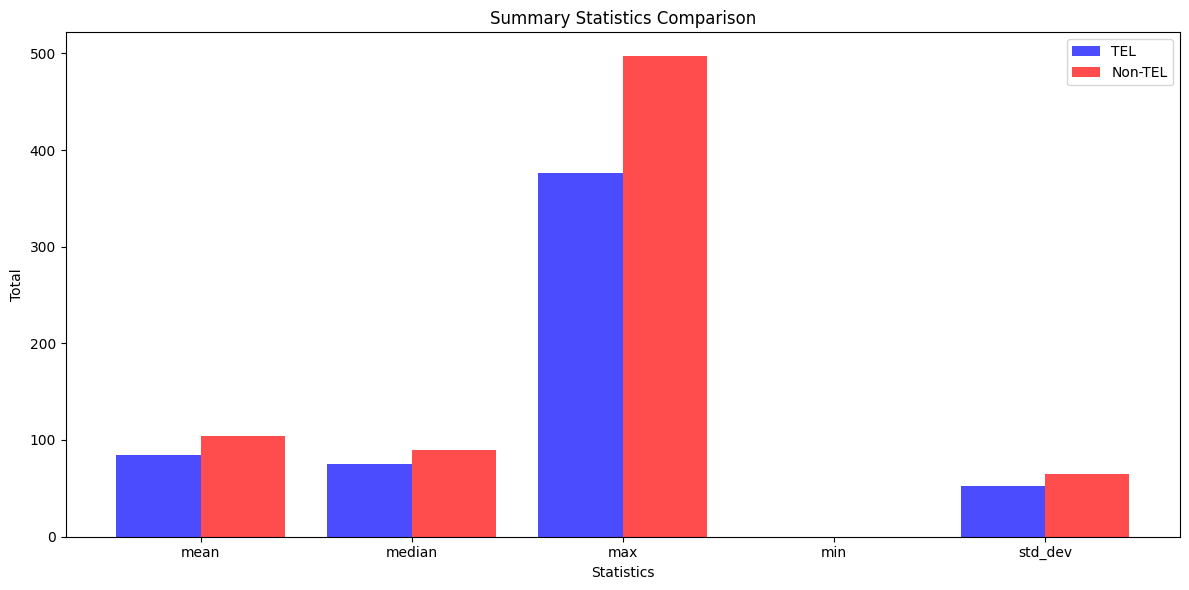

In [12]:
# Provide visualization of the results
import matplotlib.pyplot as plt

def plot_summary_statistics(summary_stats):
    """
    Plot summary statistics for the total scores of two DataFrames.

    Args:
        summary_stats (dict): Summary statistics for both DataFrames
    """
    categories = list(summary_stats['Threatening'].keys())
    tel_values = [summary_stats['Threatening'][cat] for cat in categories]
    non_tel_values = [summary_stats['Non-Threatening'][cat] for cat in categories]

    x = range(len(categories))

    plt.figure(figsize=(12, 6))
    plt.bar(x, tel_values, width=0.4, label='TEL', alpha=0.7, color='b', align='center')
    plt.bar([p + 0.4 for p in x], non_tel_values, width=0.4, label='Non-TEL', alpha=0.7, color='r', align='center')
    plt.title('Summary Statistics Comparison')
    plt.xlabel('Statistics')
    plt.ylabel('Total')
    plt.xticks([p + 0.2 for p in x], categories)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot the summary statistics
plot_summary_statistics(summary_stats)


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import defaultdict, Counter
import numpy as np

def extract_word_frequencies(df, top_n=10):
    """
    Extract word frequencies from each category column and get top N words per category.
    
    Parameters:
    df: DataFrame with columns containing lists of tuples (word, frequency)
    top_n: Number of top words to extract per category
    
    Returns:
    Dictionary with category names as keys and list of (word, frequency) tuples as values
    """
    # Get all columns except 'text' and 'total'
    category_columns = [col for col in df.columns if col not in ['text', 'total']]
    
    category_word_freq = {}
    
    for col in category_columns:
        word_counter = Counter()
        
        for idx, row in df.iterrows():
            cell_value = row[col]
            
            # Skip empty/null values
            if cell_value is None or (isinstance(cell_value, str) and cell_value.lower() in ['missing value', 'nan', 'none', '']):
                continue
            
            # Handle different data types
            parsed_value = None
            
            if isinstance(cell_value, list):
                parsed_value = cell_value
            elif isinstance(cell_value, str):
                if cell_value.strip().startswith('[') and cell_value.strip().endswith(']'):
                    try:
                        parsed_value = ast.literal_eval(cell_value.strip())
                    except (ValueError, SyntaxError):
                        continue
            
            # Extract word frequencies
            if isinstance(parsed_value, list):
                for item in parsed_value:
                    if isinstance(item, tuple) and len(item) >= 2:
                        try:
                            word = str(item[0])
                            freq = float(item[1])
                            word_counter[word] += freq
                        except (ValueError, TypeError):
                            continue
        
        # Get top N words for this category
        category_word_freq[col] = word_counter.most_common(top_n)
    
    return category_word_freq

def create_category_visualization(df, top_n=10, figsize=(15, 12)):
    """
    Create comprehensive visualizations for word frequencies across categories.
    """
    # Extract word frequencies
    category_freq = extract_word_frequencies(df, top_n)
    
    # Remove empty categories
    category_freq = {k: v for k, v in category_freq.items() if v}
    
    if not category_freq:
        print("No valid word rating data found!")
        return
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Calculate number of subplots needed
    n_categories = len(category_freq)
    cols = 3
    rows = (n_categories + cols - 1) // cols
    
    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = [axes] if n_categories == 1 else axes
    else:
        axes = axes.flatten()
    
    # Plot each category
    for idx, (category, word_freq_list) in enumerate(category_freq.items()):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        
        if not word_freq_list:
            ax.text(0.5, 0.5, f'No data for\n{category}', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{category} (No Data)')
            continue
        
        # Prepare data for plotting
        words = [item[0] for item in word_freq_list]
        frequencies = [item[1] for item in word_freq_list]
        
        # Create horizontal bar plot
        bars = ax.barh(range(len(words)), frequencies)
        
        # Customize the plot
        ax.set_yticks(range(len(words)))
        ax.set_yticklabels(words)
        ax.set_xlabel('Total Rating')
        ax.set_title(f'Top {len(words)} Words - {category}', fontweight='bold')
        
        # Add value labels on bars
        for i, (bar, freq) in enumerate(zip(bars, frequencies)):
            width = bar.get_width()
            ax.text(width + max(frequencies) * 0.01, bar.get_y() + bar.get_height()/2, 
                   f'{freq:.1f}', ha='left', va='center', fontsize=9)
        
        # Invert y-axis to show highest frequency at top
        ax.invert_yaxis()
        
        # Add grid for better readability
        ax.grid(axis='x', alpha=0.3)
    
    # Hide empty subplots
    for idx in range(n_categories, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('Word Rating Analysis by Category', fontsize=16, fontweight='bold', y=1.02)
    plt.show()

def create_summary_heatmap(df, top_n=5):
    """
    Create a heatmap showing top words across all categories.
    """
    category_freq = extract_word_frequencies(df, top_n * 2)  # Get more words for better heatmap
    
    if not category_freq:
        print("No valid word rating data found for heatmap!")
        return
    
    # Collect all unique words
    all_words = set()
    for word_list in category_freq.values():
        all_words.update([word for word, freq in word_list])
    
    # Create matrix
    categories = list(category_freq.keys())
    words_list = list(all_words)
    
    # Create frequency matrix
    freq_matrix = np.zeros((len(words_list), len(categories)))
    
    for cat_idx, category in enumerate(categories):
        word_freq_dict = dict(category_freq[category])
        for word_idx, word in enumerate(words_list):
            freq_matrix[word_idx, cat_idx] = word_freq_dict.get(word, 0)
    
    # Keep only words that appear in at least one category with significant frequency
    word_max_freq = freq_matrix.max(axis=1)
    significant_words_mask = word_max_freq > np.percentile(word_max_freq[word_max_freq > 0], 70)
    
    if not any(significant_words_mask):
        print("No significant words found for heatmap!")
        return
    
    # Filter data
    filtered_matrix = freq_matrix[significant_words_mask]
    filtered_words = [words_list[i] for i in range(len(words_list)) if significant_words_mask[i]]
    
    # Create heatmap
    plt.figure(figsize=(12, max(6, len(filtered_words) * 0.3)))
    
    # Create DataFrame for seaborn
    heatmap_df = pd.DataFrame(filtered_matrix, 
                             index=filtered_words, 
                             columns=categories)
    
    sns.heatmap(heatmap_df, annot=True, fmt='.1f', cmap='YlOrRd', 
                cbar_kws={'label': 'Total Rating'})
    
    plt.title('Word Rating Heatmap Across Categories', fontweight='bold', pad=20)
    plt.xlabel('Categories')
    plt.ylabel('Words')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def create_top_words_comparison(df, top_n=15):
    """
    Create a comparison chart of the most frequent words overall.
    """
    category_freq = extract_word_frequencies(df, top_n * 3)
    
    if not category_freq:
        print("No valid word rating data found for comparison!")
        return
    
    # Aggregate all words across categories
    overall_counter = Counter()
    
    for category, word_list in category_freq.items():
        for word, freq in word_list:
            overall_counter[word] += freq
    
    # Get top words overall
    top_words = overall_counter.most_common(top_n)
    
    if not top_words:
        print("No words found for comparison chart!")
        return
    
    # Create the plot
    words = [item[0] for item in top_words]
    frequencies = [item[1] for item in top_words]
    
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(words)), frequencies, color=plt.cm.viridis(np.linspace(0, 1, len(words))))
    
    plt.yticks(range(len(words)), words)
    plt.xlabel('Total Rating Across All Categories')
    plt.title(f'Top {top_n} Highest Rated Words Overall', fontweight='bold', pad=20)
    
    # Add value labels
    for i, (bar, freq) in enumerate(zip(bars, frequencies)):
        width = bar.get_width()
        plt.text(width + max(frequencies) * 0.01, bar.get_y() + bar.get_height()/2, 
                f'{freq:.1f}', ha='left', va='center', fontweight='bold')
    
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage:
"""
# Assuming your DataFrame is called 'matched_words_tel_df'
# Replace this with your actual DataFrame variable name

# Create individual category visualizations
# create_category_visualization(matched_words_tel_df, top_n=10)

# Create heatmap comparison
create_summary_heatmap(matched_words_tel_df, top_n=8)

# Create overall top words comparison
create_top_words_comparison(matched_words_tel_df, top_n=15)

# You can also get the raw data for further analysis:
word_freq_data = extract_word_frequencies(matched_words_tel_df, top_n=10)
print("\\nCategory breakdown:")
for category, words in word_freq_data.items():
    print(f"\\n{category}:")
    for word, freq in words[:5]:  # Show top 5
        print(f"  {word}: {freq:.2f}")
"""

'\n# Assuming your DataFrame is called \'matched_words_tel_df\'\n# Replace this with your actual DataFrame variable name\n\n# Create individual category visualizations\n# create_category_visualization(matched_words_tel_df, top_n=10)\n\n# Create heatmap comparison\ncreate_summary_heatmap(matched_words_tel_df, top_n=8)\n\n# Create overall top words comparison\ncreate_top_words_comparison(matched_words_tel_df, top_n=15)\n\n# You can also get the raw data for further analysis:\nword_freq_data = extract_word_frequencies(matched_words_tel_df, top_n=10)\nprint("\\nCategory breakdown:")\nfor category, words in word_freq_data.items():\n    print(f"\\n{category}:")\n    for word, freq in words[:5]:  # Show top 5\n        print(f"  {word}: {freq:.2f}")\n'

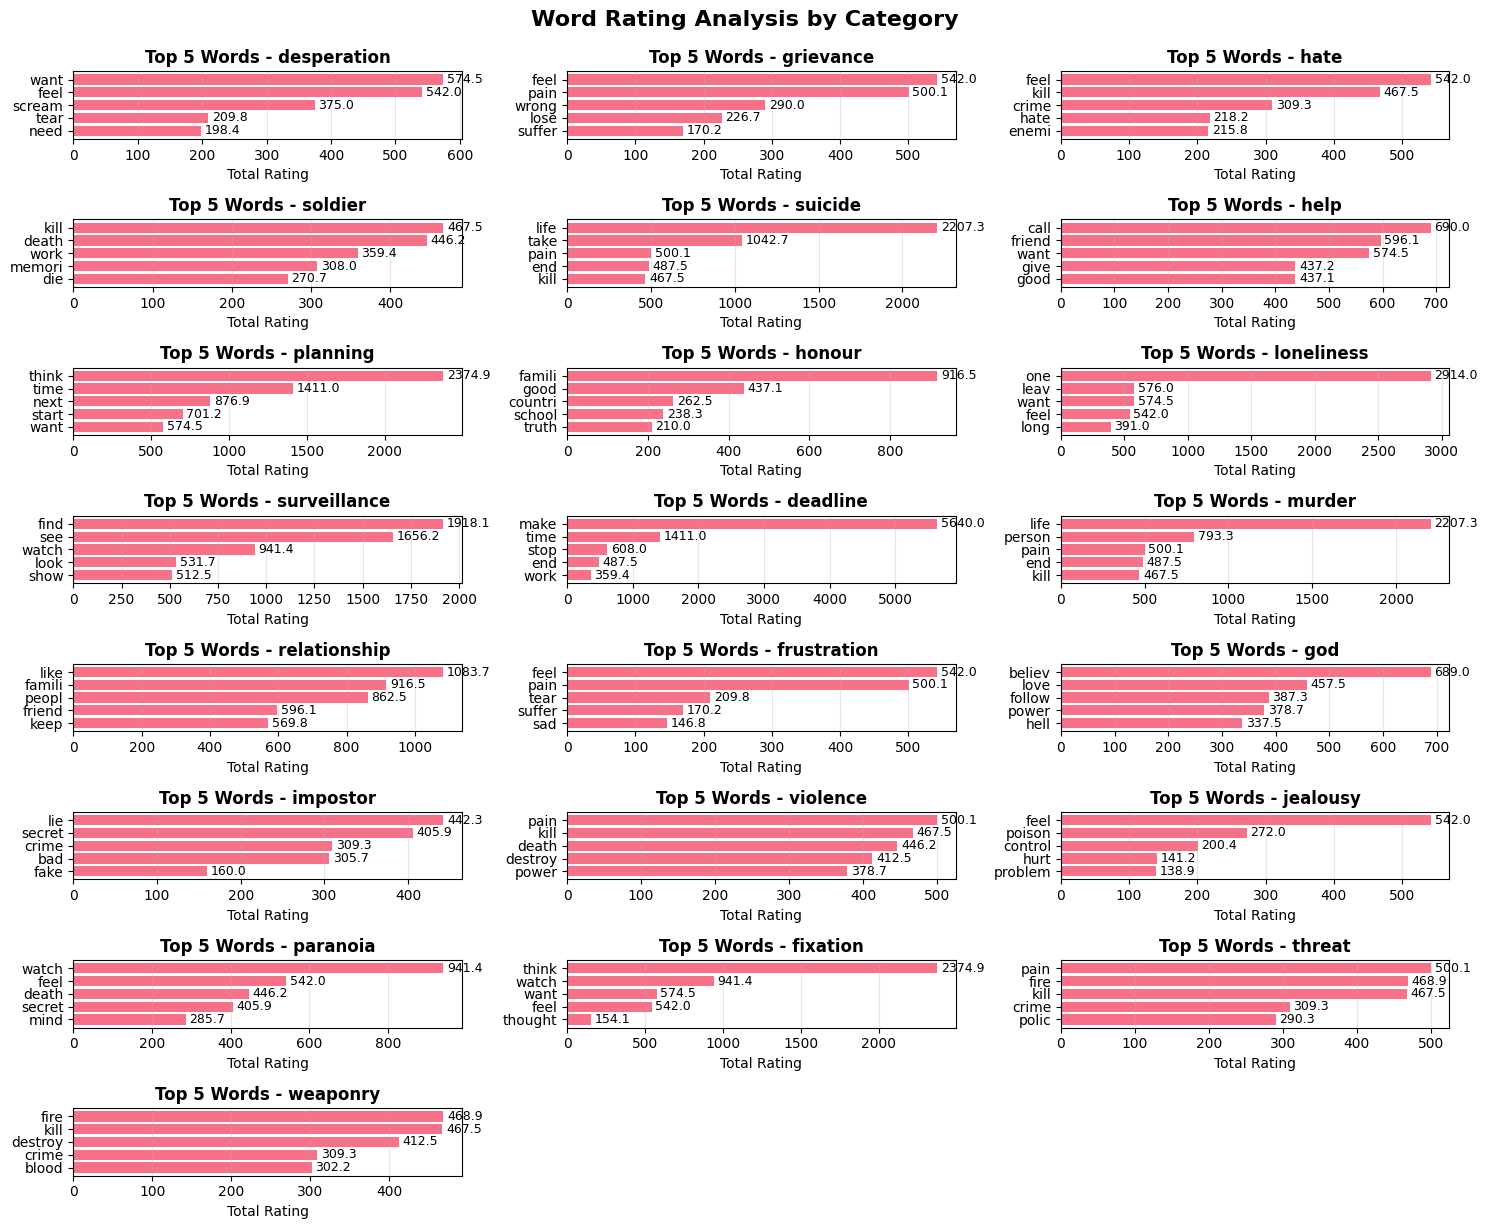

In [14]:
create_category_visualization(matched_words_tel_with_total_df, top_n=5)

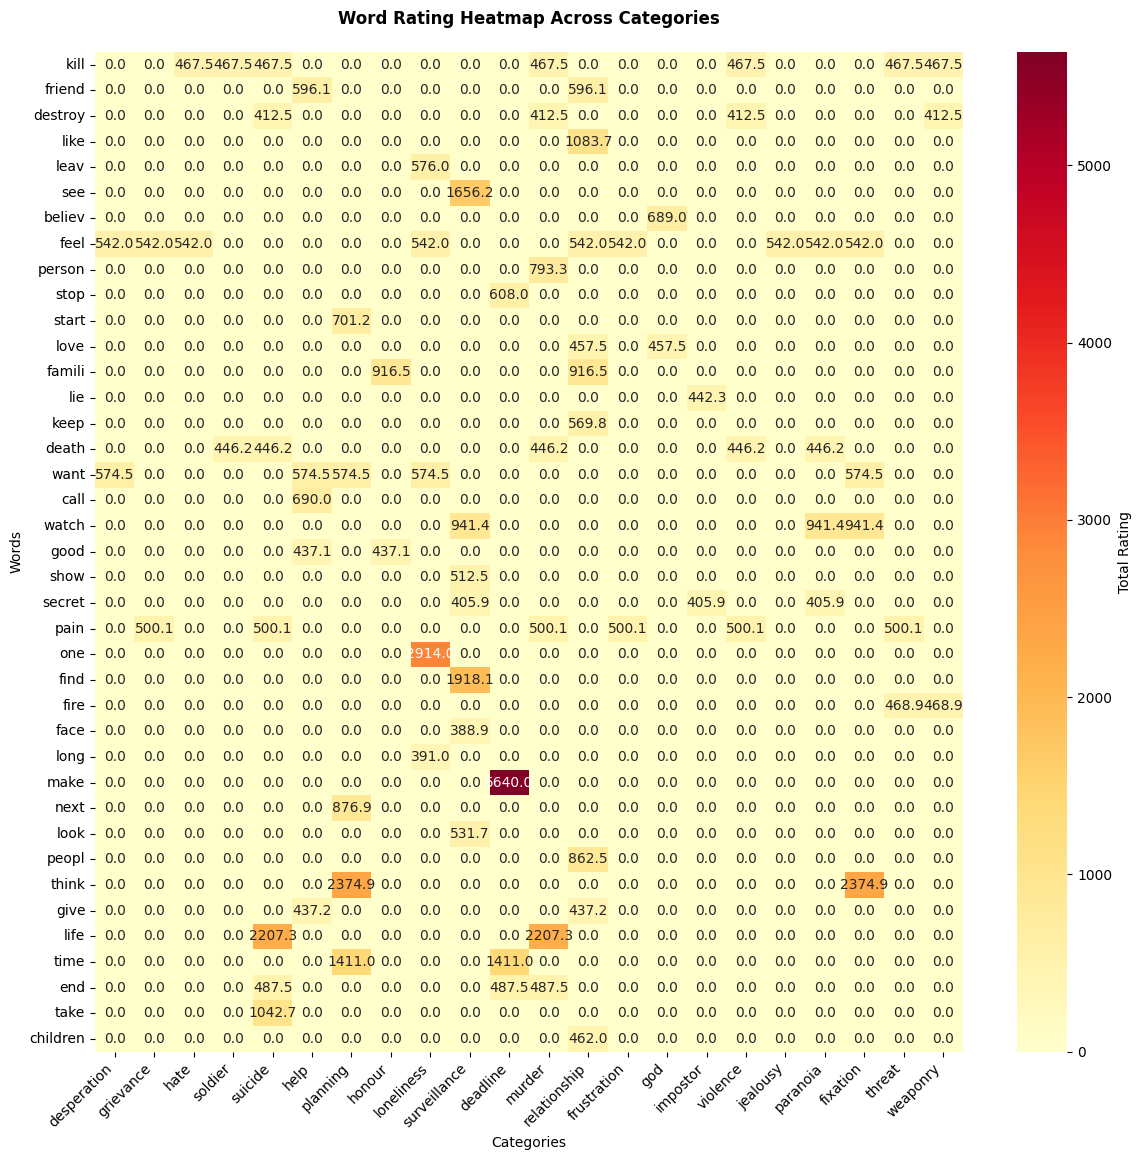

In [15]:
create_summary_heatmap(matched_words_tel_with_total_df, top_n=5)

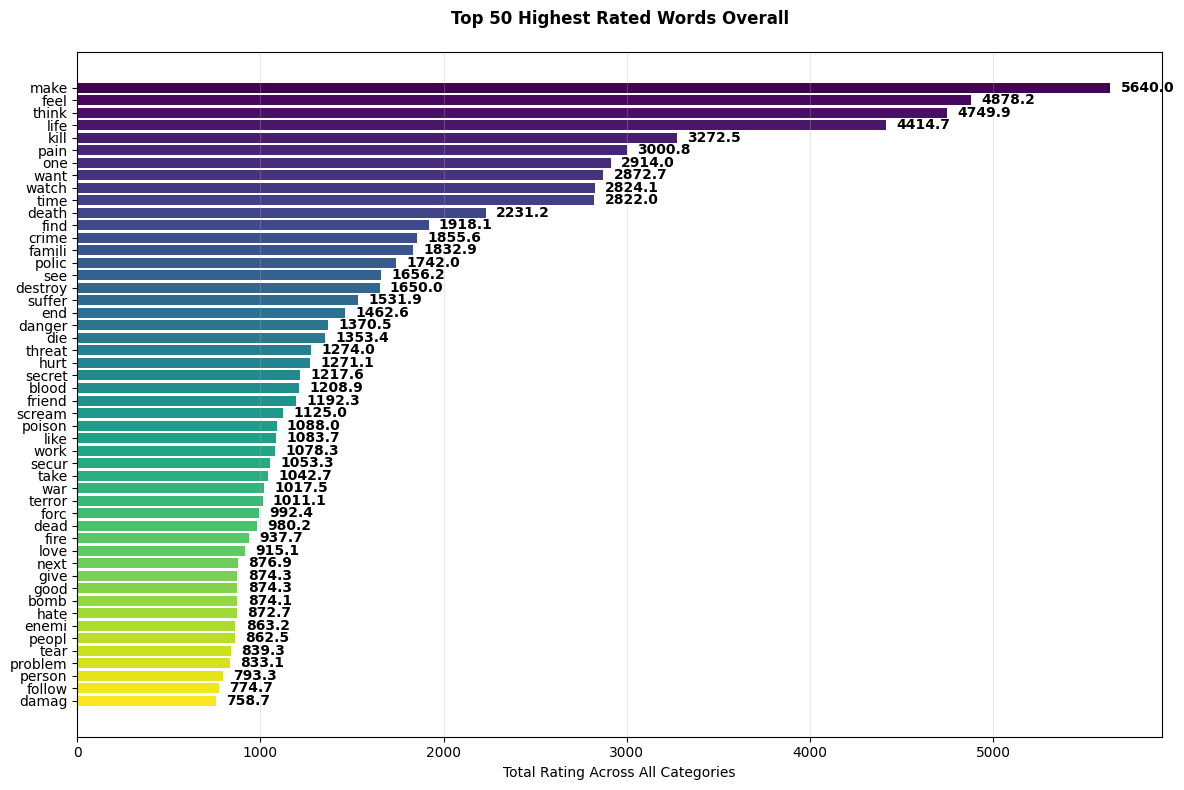

In [16]:
create_top_words_comparison(matched_words_tel_with_total_df, top_n=50)

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import defaultdict, Counter
import numpy as np

def extract_word_ratings(df, top_n=10):
    """
    Extract word ratings from each category column and get top N highest-rated words per category.
    
    Parameters:
    df: DataFrame with columns containing lists of tuples (word, mean_rating)
    top_n: Number of top rated words to extract per category
    
    Returns:
    Dictionary with category names as keys and list of (word, mean_rating) tuples as values
    """
    # Get all columns except 'text' and 'total'
    category_columns = [col for col in df.columns if col not in ['text', 'total']]
    
    category_word_freq = {}
    
    for col in category_columns:
        word_ratings = {}  # Use dict to store highest rating per word
        
        for idx, row in df.iterrows():
            cell_value = row[col]
            
            # Skip empty/null values
            if cell_value is None or (isinstance(cell_value, str) and cell_value.lower() in ['missing value', 'nan', 'none', '']):
                continue
            
            # Handle different data types
            parsed_value = None
            
            if isinstance(cell_value, list):
                parsed_value = cell_value
            elif isinstance(cell_value, str):
                if cell_value.strip().startswith('[') and cell_value.strip().endswith(']'):
                    try:
                        parsed_value = ast.literal_eval(cell_value.strip())
                    except (ValueError, SyntaxError):
                        continue
            
            # Extract word ratings - keep the highest rating for each word
            if isinstance(parsed_value, list):
                for item in parsed_value:
                    if isinstance(item, tuple) and len(item) >= 2:
                        try:
                            word = str(item[0])
                            rating = float(item[1])
                            # Keep the highest rating for each word
                            if word not in word_ratings or rating > word_ratings[word]:
                                word_ratings[word] = rating
                        except (ValueError, TypeError):
                            continue
        
        # Sort by rating (highest first) and get top N
        sorted_words = sorted(word_ratings.items(), key=lambda x: x[1], reverse=True)
        category_word_freq[col] = sorted_words[:top_n]
    
    return category_word_freq

def create_category_visualization(df, top_n=10, figsize=(15, 12)):
    """
    Create comprehensive visualizations for word TEL ratings across categories.
    """
    # Extract word ratings
    category_ratings = extract_word_ratings(df, top_n)
    
    # Remove empty categories
    category_ratings = {k: v for k, v in category_ratings.items() if v}
    
    if not category_ratings:
        print("No valid word rating data found!")
        return
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Calculate number of subplots needed
    n_categories = len(category_ratings)
    cols = 3
    rows = (n_categories + cols - 1) // cols
    
    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = [axes] if n_categories == 1 else axes
    else:
        axes = axes.flatten()
    
    # Plot each category
    for idx, (category, word_rating_list) in enumerate(category_ratings.items()):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        
        if not word_rating_list:
            ax.text(0.5, 0.5, f'No data for\n{category}', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{category} (No Data)')
            continue
        
        # Prepare data for plotting
        words = [item[0] for item in word_rating_list]
        ratings = [item[1] for item in word_rating_list]
        
        # Create color map based on rating intensity (red = higher TEL rating)
        colors = plt.cm.Reds(np.array(ratings) / 10.0)  # Normalize to 0-1 for colormap
        
        # Create horizontal bar plot
        bars = ax.barh(range(len(words)), ratings, color=colors)
        
        # Customize the plot
        ax.set_yticks(range(len(words)))
        ax.set_yticklabels(words)
        ax.set_xlabel('TEL Rating (1-10 scale)')
        ax.set_title(f'Top {len(words)} Highest TEL-Rated Words - {category}', fontweight='bold')
        ax.set_xlim(0, 10)  # Set consistent scale
        
        # Add value labels on bars
        for i, (bar, rating) in enumerate(zip(bars, ratings)):
            width = bar.get_width()
            ax.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
                   f'{rating:.2f}', ha='left', va='center', fontsize=9, fontweight='bold')
        
        # Invert y-axis to show highest rating at top
        ax.invert_yaxis()
        
        # Add grid for better readability
        ax.grid(axis='x', alpha=0.3)
        
        # Add background color zones for rating levels
        ax.axvspan(0, 3, alpha=0.1, color='green', label='Low TEL')
        ax.axvspan(3, 7, alpha=0.1, color='yellow', label='Medium TEL')
        ax.axvspan(7, 10, alpha=0.1, color='red', label='High TEL')
    
    # Hide empty subplots
    for idx in range(n_categories, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('TEL (Threatening English Language) Rating Analysis by Category', fontsize=16, fontweight='bold', y=1.02)
    plt.show()

def create_summary_heatmap(df, top_n=5):
    """
    Create a heatmap showing highest TEL-rated words across all categories.
    """
    category_ratings = extract_word_ratings(df, top_n * 2)  # Get more words for better heatmap
    
    if not category_ratings:
        print("No valid word rating data found for heatmap!")
        return
    
    # Collect all unique words
    all_words = set()
    for word_list in category_ratings.values():
        all_words.update([word for word, rating in word_list])
    
    # Create matrix
    categories = list(category_ratings.keys())
    words_list = list(all_words)
    
    # Create rating matrix
    rating_matrix = np.zeros((len(words_list), len(categories)))
    
    for cat_idx, category in enumerate(categories):
        word_rating_dict = dict(category_ratings[category])
        for word_idx, word in enumerate(words_list):
            rating_matrix[word_idx, cat_idx] = word_rating_dict.get(word, 0)
    
    # Keep only words that appear in at least one category with significant rating
    word_max_rating = rating_matrix.max(axis=1)
    significant_words_mask = word_max_rating > np.percentile(word_max_rating[word_max_rating > 0], 70)
    
    if not any(significant_words_mask):
        print("No significant words found for heatmap!")
        return
    
    # Filter data
    filtered_matrix = rating_matrix[significant_words_mask]
    filtered_words = [words_list[i] for i in range(len(words_list)) if significant_words_mask[i]]
    
    # Create heatmap
    plt.figure(figsize=(12, max(6, len(filtered_words) * 0.3)))
    
    # Create DataFrame for seaborn
    heatmap_df = pd.DataFrame(filtered_matrix, 
                             index=filtered_words, 
                             columns=categories)
    
    sns.heatmap(heatmap_df, annot=True, fmt='.2f', cmap='Reds', 
                cbar_kws={'label': 'TEL Rating (1-10)'}, vmin=0, vmax=10)
    
    plt.title('TEL Rating Heatmap: Highest-Rated Words Across Categories', fontweight='bold', pad=20)
    plt.xlabel('Categories')
    plt.ylabel('Words')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def create_top_words_comparison(df, top_n=15):
    """
    Create a comparison chart of the highest TEL-rated words overall.
    """
    category_ratings = extract_word_ratings(df, top_n * 3)
    
    if not category_ratings:
        print("No valid word rating data found for comparison!")
        return
    
    # Find the highest rating for each word across all categories
    overall_ratings = {}
    
    for category, word_list in category_ratings.items():
        for word, rating in word_list:
            if word not in overall_ratings or rating > overall_ratings[word]:
                overall_ratings[word] = rating
    
    # Get top words overall by highest rating
    top_words = sorted(overall_ratings.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    if not top_words:
        print("No words found for comparison chart!")
        return
    
    # Create the plot
    words = [item[0] for item in top_words]
    ratings = [item[1] for item in top_words]
    
    plt.figure(figsize=(12, 8))
    
    # Create color gradient based on rating (darker red = higher TEL rating)
    colors = plt.cm.Reds(np.array(ratings) / 10.0)
    bars = plt.barh(range(len(words)), ratings, color=colors)
    
    plt.yticks(range(len(words)), words)
    plt.xlabel('TEL Rating (1-10 scale)')
    plt.title(f'Top {top_n} Highest TEL-Rated Words Overall', fontweight='bold', pad=20)
    plt.xlim(0, 10)
    
    # Add value labels
    for i, (bar, rating) in enumerate(zip(bars, ratings)):
        width = bar.get_width()
        plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{rating:.2f}', ha='left', va='center', fontweight='bold')
    
    # Add background color zones for rating interpretation
    plt.axvspan(0, 3, alpha=0.1, color='green', label='Low TEL (1-3)')
    plt.axvspan(3, 7, alpha=0.1, color='yellow', label='Medium TEL (3-7)')
    plt.axvspan(7, 10, alpha=0.1, color='red', label='High TEL (7-10)')
    plt.legend(loc='lower right')
    
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage:
"""
# Assuming your DataFrame is called 'matched_words_tel_df'
# Replace this with your actual DataFrame variable name

# Create individual category visualizations showing highest TEL-rated words
create_category_visualization(matched_words_tel_df, top_n=10)

# Create heatmap comparison of TEL ratings across categories
create_summary_heatmap(matched_words_tel_df, top_n=8)

# Create overall comparison of highest TEL-rated words
create_top_words_comparison(matched_words_tel_df, top_n=15)

# You can also get the raw data for further analysis:
word_rating_data = extract_word_ratings(matched_words_tel_df, top_n=10)
print("\\nCategory breakdown (Highest TEL-rated words):")
for category, words in word_rating_data.items():
    print(f"\\n{category}:")
    for word, rating in words[:5]:  # Show top 5
        print(f"  {word}: {rating:.2f}/10 TEL rating")
"""

'\n# Assuming your DataFrame is called \'matched_words_tel_df\'\n# Replace this with your actual DataFrame variable name\n\n# Create individual category visualizations showing highest TEL-rated words\ncreate_category_visualization(matched_words_tel_df, top_n=10)\n\n# Create heatmap comparison of TEL ratings across categories\ncreate_summary_heatmap(matched_words_tel_df, top_n=8)\n\n# Create overall comparison of highest TEL-rated words\ncreate_top_words_comparison(matched_words_tel_df, top_n=15)\n\n# You can also get the raw data for further analysis:\nword_rating_data = extract_word_ratings(matched_words_tel_df, top_n=10)\nprint("\\nCategory breakdown (Highest TEL-rated words):")\nfor category, words in word_rating_data.items():\n    print(f"\\n{category}:")\n    for word, rating in words[:5]:  # Show top 5\n        print(f"  {word}: {rating:.2f}/10 TEL rating")\n'

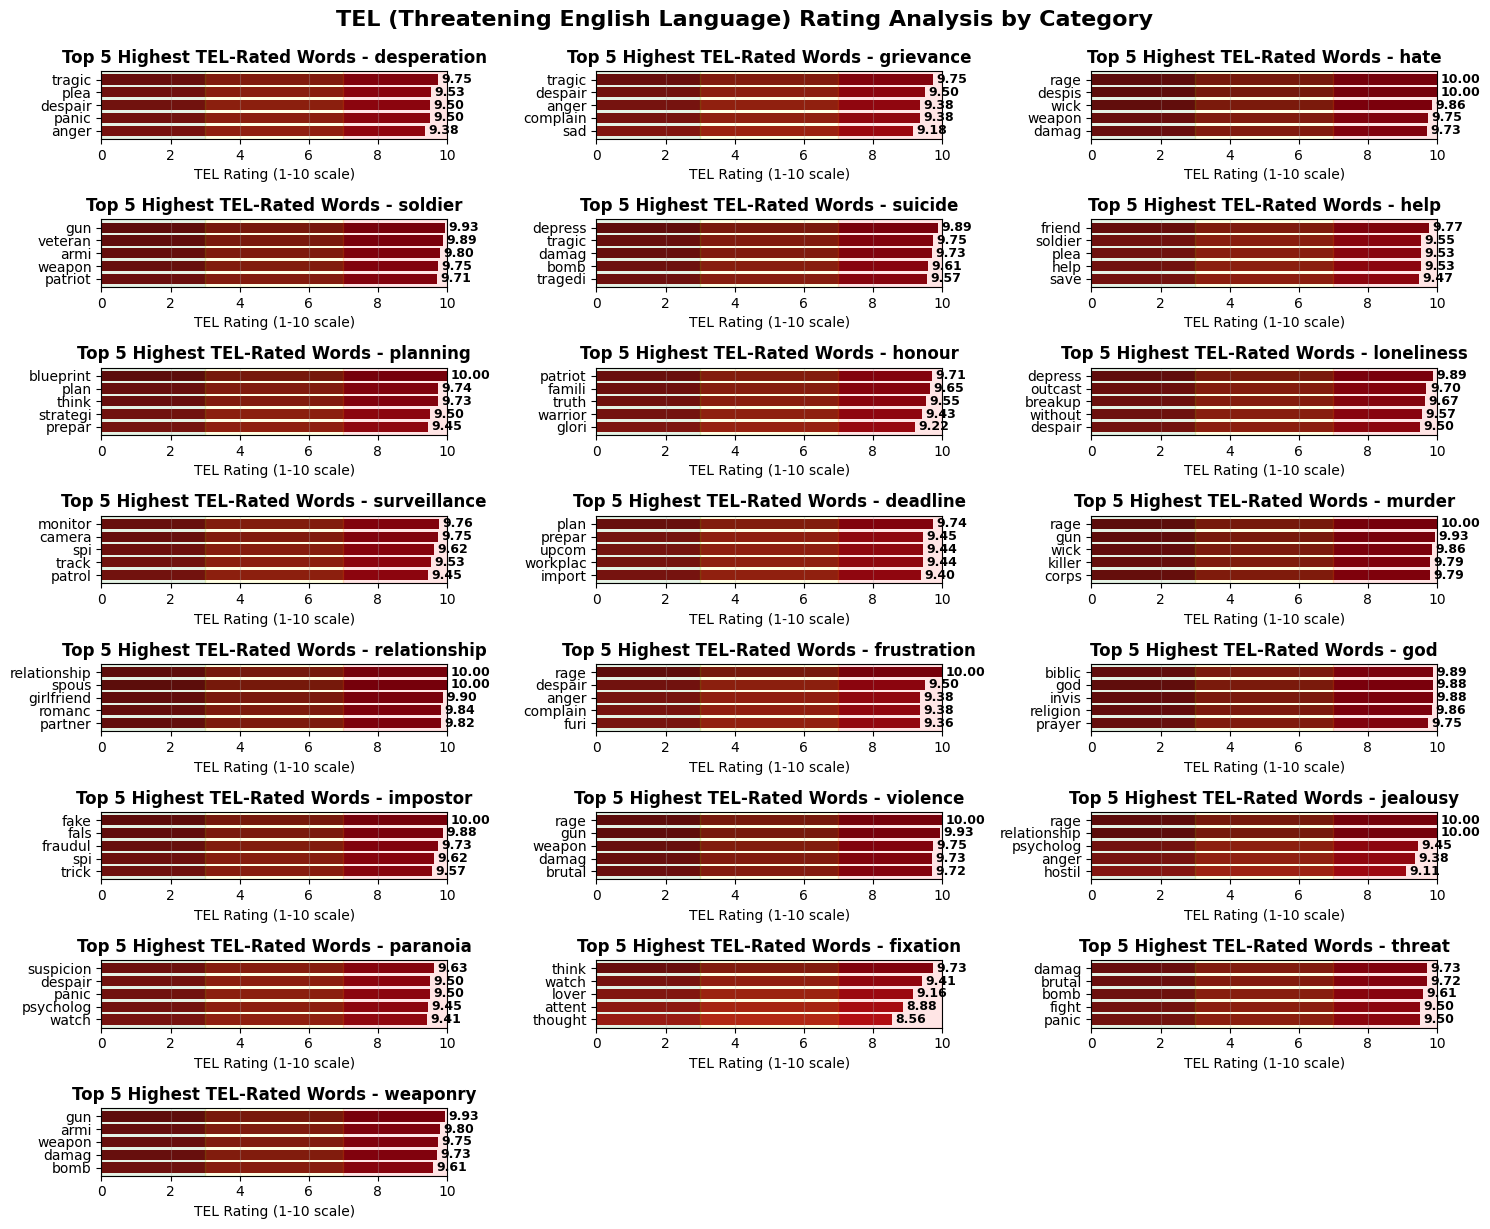

In [18]:
create_category_visualization(matched_words_tel_with_total_df, top_n=5)

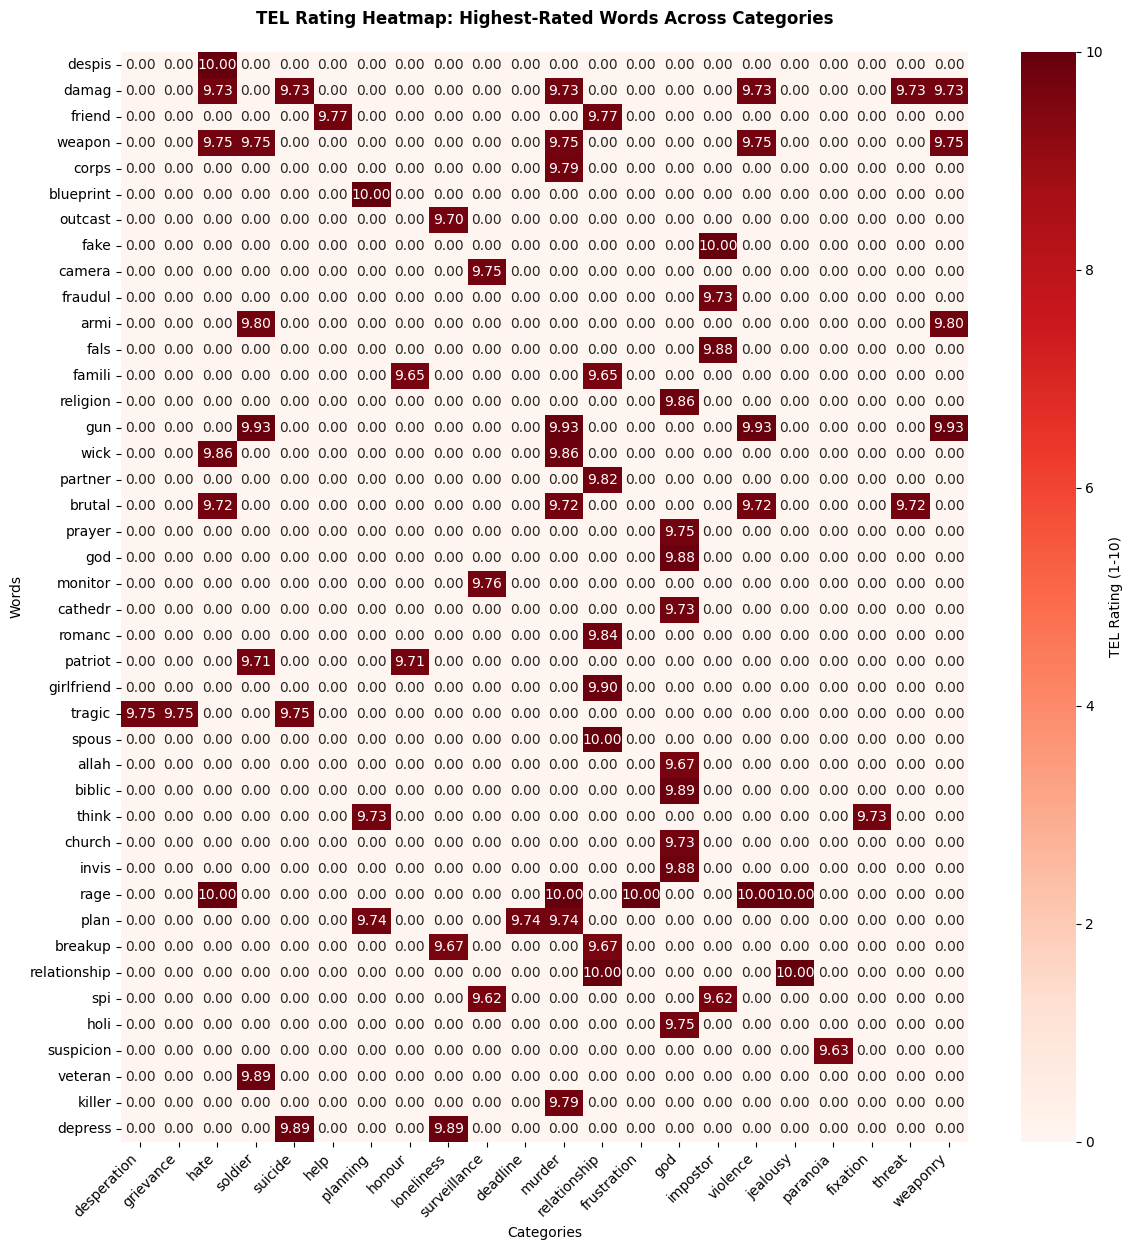

In [19]:
create_summary_heatmap(matched_words_tel_with_total_df, top_n=5)

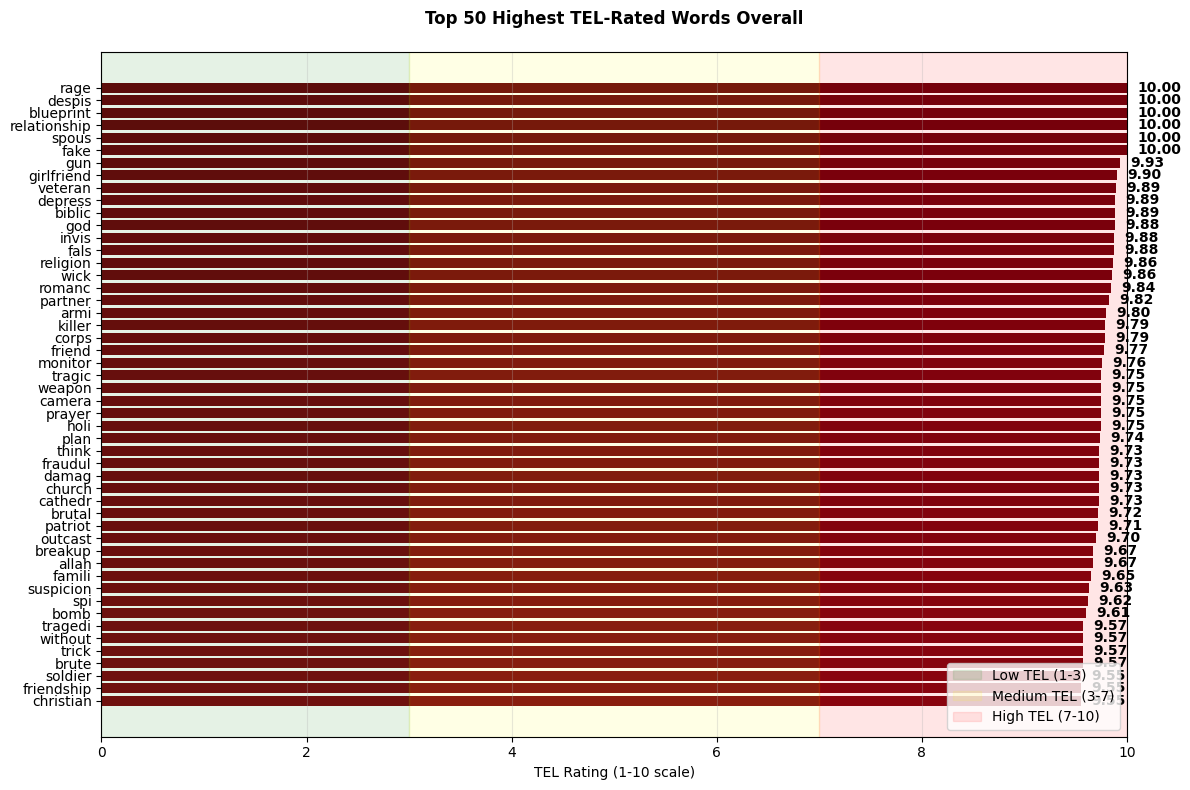

In [20]:
create_top_words_comparison(matched_words_tel_with_total_df, top_n=50)

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import defaultdict, Counter
import numpy as np

def extract_word_counts(df, top_n=10):
    """
    Extract word counts from each category column and get top N most frequent words per category.
    
    Parameters:
    df: DataFrame with columns containing lists of tuples (word, mean_rating)
    top_n: Number of most frequent words to extract per category
    
    Returns:
    Dictionary with category names as keys and list of (word, count) tuples as values
    """
    # Get all columns except 'text' and 'total'
    category_columns = [col for col in df.columns if col not in ['text', 'total']]
    
    category_word_counts = {}
    
    for col in category_columns:
        word_counter = Counter()
        
        for idx, row in df.iterrows():
            cell_value = row[col]
            
            # Skip empty/null values
            if cell_value is None or (isinstance(cell_value, str) and cell_value.lower() in ['missing value', 'nan', 'none', '']):
                continue
            
            # Handle different data types
            parsed_value = None
            
            if isinstance(cell_value, list):
                parsed_value = cell_value
            elif isinstance(cell_value, str):
                if cell_value.strip().startswith('[') and cell_value.strip().endswith(']'):
                    try:
                        parsed_value = ast.literal_eval(cell_value.strip())
                    except (ValueError, SyntaxError):
                        continue
            
            # Count word occurrences (each word appearance counts as 1)
            if isinstance(parsed_value, list):
                for item in parsed_value:
                    if isinstance(item, tuple) and len(item) >= 2:
                        try:
                            word = str(item[0])
                            # Count each occurrence of the word (ignore the rating)
                            word_counter[word] += 1
                        except (ValueError, TypeError):
                            continue
        
        # Get top N most frequent words for this category
        category_word_counts[col] = word_counter.most_common(top_n)
    
    return category_word_counts

def create_count_visualization(df, top_n=10, figsize=(15, 12)):
    """
    Create comprehensive visualizations for word counts across categories.
    """
    # Extract word counts
    category_counts = extract_word_counts(df, top_n)
    
    # Remove empty categories
    category_counts = {k: v for k, v in category_counts.items() if v}
    
    if not category_counts:
        print("No valid word count data found!")
        return
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Calculate number of subplots needed
    n_categories = len(category_counts)
    cols = 3
    rows = (n_categories + cols - 1) // cols
    
    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = [axes] if n_categories == 1 else axes
    else:
        axes = axes.flatten()
    
    # Plot each category
    for idx, (category, word_count_list) in enumerate(category_counts.items()):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        
        if not word_count_list:
            ax.text(0.5, 0.5, f'No data for\n{category}', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{category} (No Data)')
            continue
        
        # Prepare data for plotting
        words = [item[0] for item in word_count_list]
        counts = [item[1] for item in word_count_list]
        
        # Create color map based on count frequency (blue gradient)
        max_count = max(counts) if counts else 1
        colors = plt.cm.Blues(np.array(counts) / max_count)
        
        # Create horizontal bar plot
        bars = ax.barh(range(len(words)), counts, color=colors)
        
        # Customize the plot
        ax.set_yticks(range(len(words)))
        ax.set_yticklabels(words)
        ax.set_xlabel('Word Count (Frequency of Appearance)')
        ax.set_title(f'Top {len(words)} Most Frequent Words - {category}', fontweight='bold')
        
        # Add value labels on bars
        for i, (bar, count) in enumerate(zip(bars, counts)):
            width = bar.get_width()
            ax.text(width + max_count * 0.01, bar.get_y() + bar.get_height()/2, 
                   f'{count}', ha='left', va='center', fontsize=9, fontweight='bold')
        
        # Invert y-axis to show highest count at top
        ax.invert_yaxis()
        
        # Add grid for better readability
        ax.grid(axis='x', alpha=0.3)
    
    # Hide empty subplots
    for idx in range(n_categories, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('Word Count Analysis by Category (Frequency of Appearance)', fontsize=16, fontweight='bold', y=1.02)
    plt.show()

def create_count_heatmap(df, top_n=5):
    """
    Create a heatmap showing word counts across all categories.
    """
    category_counts = extract_word_counts(df, top_n * 2)  # Get more words for better heatmap
    
    if not category_counts:
        print("No valid word count data found for heatmap!")
        return
    
    # Collect all unique words
    all_words = set()
    for word_list in category_counts.values():
        all_words.update([word for word, count in word_list])
    
    # Create matrix
    categories = list(category_counts.keys())
    words_list = list(all_words)
    
    # Create count matrix
    count_matrix = np.zeros((len(words_list), len(categories)))
    
    for cat_idx, category in enumerate(categories):
        word_count_dict = dict(category_counts[category])
        for word_idx, word in enumerate(words_list):
            count_matrix[word_idx, cat_idx] = word_count_dict.get(word, 0)
    
    # Keep only words that appear in at least one category with significant count
    word_max_count = count_matrix.max(axis=1)
    significant_words_mask = word_max_count > np.percentile(word_max_count[word_max_count > 0], 70)
    
    if not any(significant_words_mask):
        print("No significant words found for heatmap!")
        return
    
    # Filter data
    filtered_matrix = count_matrix[significant_words_mask]
    filtered_words = [words_list[i] for i in range(len(words_list)) if significant_words_mask[i]]
    
    # Create heatmap
    plt.figure(figsize=(12, max(6, len(filtered_words) * 0.3)))
    
    # Create DataFrame for seaborn
    heatmap_df = pd.DataFrame(filtered_matrix, 
                             index=filtered_words, 
                             columns=categories)
    
    sns.heatmap(heatmap_df, annot=True, fmt='.0f', cmap='Blues', 
                cbar_kws={'label': 'Word Count'})
    
    plt.title('Word Count Heatmap: Most Frequent Words Across Categories', fontweight='bold', pad=20)
    plt.xlabel('Categories')
    plt.ylabel('Words')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def create_top_count_comparison(df, top_n=15):
    """
    Create a comparison chart of the most frequently occurring words overall.
    """
    category_counts = extract_word_counts(df, top_n * 3)
    
    if not category_counts:
        print("No valid word count data found for comparison!")
        return
    
    # Aggregate counts across all categories
    overall_counter = Counter()
    
    for category, word_list in category_counts.items():
        for word, count in word_list:
            overall_counter[word] += count
    
    # Get top words overall by count
    top_words = overall_counter.most_common(top_n)
    
    if not top_words:
        print("No words found for comparison chart!")
        return
    
    # Create the plot
    words = [item[0] for item in top_words]
    counts = [item[1] for item in top_words]
    
    plt.figure(figsize=(12, 8))
    
    # Create color gradient based on count (darker blue = higher count)
    max_count = max(counts) if counts else 1
    colors = plt.cm.Blues(np.array(counts) / max_count)
    bars = plt.barh(range(len(words)), counts, color=colors)
    
    plt.yticks(range(len(words)), words)
    plt.xlabel('Total Word Count Across All Categories')
    plt.title(f'Top {top_n} Most Frequently Occurring Words Overall', fontweight='bold', pad=20)
    
    # Add value labels
    for i, (bar, count) in enumerate(zip(bars, counts)):
        width = bar.get_width()
        plt.text(width + max_count * 0.01, bar.get_y() + bar.get_height()/2, 
                f'{count}', ha='left', va='center', fontweight='bold')
    
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

def create_count_vs_rating_comparison(df, top_n=10):
    """
    Create a comparison showing both count and average rating for top words.
    This function combines both approaches for comprehensive analysis.
    """
    # Get word counts
    category_counts = extract_word_counts(df, top_n * 2)
    
    # Get word ratings (reuse the function from rating analysis)
    from collections import defaultdict
    
    # Extract both counts and ratings
    word_stats = defaultdict(lambda: {'count': 0, 'ratings': []})
    
    # Get all columns except 'text' and 'total'
    category_columns = [col for col in df.columns if col not in ['text', 'total']]
    
    for col in category_columns:
        for idx, row in df.iterrows():
            cell_value = row[col]
            
            # Skip empty/null values
            if cell_value is None or (isinstance(cell_value, str) and cell_value.lower() in ['missing value', 'nan', 'none', '']):
                continue
            
            # Handle different data types
            parsed_value = None
            
            if isinstance(cell_value, list):
                parsed_value = cell_value
            elif isinstance(cell_value, str):
                if cell_value.strip().startswith('[') and cell_value.strip().endswith(']'):
                    try:
                        parsed_value = ast.literal_eval(cell_value.strip())
                    except (ValueError, SyntaxError):
                        continue
            
            # Extract both count and rating
            if isinstance(parsed_value, list):
                for item in parsed_value:
                    if isinstance(item, tuple) and len(item) >= 2:
                        try:
                            word = str(item[0])
                            rating = float(item[1])
                            word_stats[word]['count'] += 1
                            word_stats[word]['ratings'].append(rating)
                        except (ValueError, TypeError):
                            continue
    
    # Calculate average ratings and get top words by count
    word_summary = []
    for word, stats in word_stats.items():
        if stats['count'] > 0:
            avg_rating = np.mean(stats['ratings'])
            word_summary.append((word, stats['count'], avg_rating))
    
    # Sort by count and get top N
    word_summary.sort(key=lambda x: x[1], reverse=True)
    top_words_data = word_summary[:top_n]
    
    if not top_words_data:
        print("No words found for count vs rating comparison!")
        return
    
    # Create the plot
    words = [item[0] for item in top_words_data]
    counts = [item[1] for item in top_words_data]
    avg_ratings = [item[2] for item in top_words_data]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot 1: Word counts
    colors1 = plt.cm.Blues(np.array(counts) / max(counts))
    bars1 = ax1.barh(range(len(words)), counts, color=colors1)
    ax1.set_yticks(range(len(words)))
    ax1.set_yticklabels(words)
    ax1.set_xlabel('Word Count')
    ax1.set_title('Most Frequent Words (by Count)', fontweight='bold')
    ax1.invert_yaxis()
    ax1.grid(axis='x', alpha=0.3)
    
    # Add count labels
    for i, (bar, count) in enumerate(zip(bars1, counts)):
        width = bar.get_width()
        ax1.text(width + max(counts) * 0.01, bar.get_y() + bar.get_height()/2, 
                f'{count}', ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Plot 2: Average ratings for the same words
    colors2 = plt.cm.Reds(np.array(avg_ratings) / 10.0)
    bars2 = ax2.barh(range(len(words)), avg_ratings, color=colors2)
    ax2.set_yticks(range(len(words)))
    ax2.set_yticklabels(words)
    ax2.set_xlabel('Average TEL Rating')
    ax2.set_title('Average TEL Ratings (same words)', fontweight='bold')
    ax2.set_xlim(0, 10)
    ax2.invert_yaxis()
    ax2.grid(axis='x', alpha=0.3)
    
    # Add rating labels
    for i, (bar, rating) in enumerate(zip(bars2, avg_ratings)):
        width = bar.get_width()
        ax2.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{rating:.2f}', ha='left', va='center', fontsize=9, fontweight='bold')
    
    plt.suptitle(f'Top {top_n} Words: Frequency vs TEL Rating Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Example usage:
"""
# Assuming your DataFrame is called 'matched_words_tel_df'
# Replace this with your actual DataFrame variable name

# Create individual category visualizations showing most frequent words
create_count_visualization(matched_words_tel_df, top_n=10)

# Create heatmap comparison of word counts across categories
create_count_heatmap(matched_words_tel_df, top_n=8)

# Create overall comparison of most frequent words
create_top_count_comparison(matched_words_tel_df, top_n=15)

# Create side-by-side comparison of count vs rating
create_count_vs_rating_comparison(matched_words_tel_df, top_n=10)

# You can also get the raw data for further analysis:
word_count_data = extract_word_counts(matched_words_tel_df, top_n=10)
print("\\nCategory breakdown (Most frequent words):")
for category, words in word_count_data.items():
    print(f"\\n{category}:")
    for word, count in words[:5]:  # Show top 5
        print(f"  {word}: appears {count} times")
"""

'\n# Assuming your DataFrame is called \'matched_words_tel_df\'\n# Replace this with your actual DataFrame variable name\n\n# Create individual category visualizations showing most frequent words\ncreate_count_visualization(matched_words_tel_df, top_n=10)\n\n# Create heatmap comparison of word counts across categories\ncreate_count_heatmap(matched_words_tel_df, top_n=8)\n\n# Create overall comparison of most frequent words\ncreate_top_count_comparison(matched_words_tel_df, top_n=15)\n\n# Create side-by-side comparison of count vs rating\ncreate_count_vs_rating_comparison(matched_words_tel_df, top_n=10)\n\n# You can also get the raw data for further analysis:\nword_count_data = extract_word_counts(matched_words_tel_df, top_n=10)\nprint("\\nCategory breakdown (Most frequent words):")\nfor category, words in word_count_data.items():\n    print(f"\\n{category}:")\n    for word, count in words[:5]:  # Show top 5\n        print(f"  {word}: appears {count} times")\n'

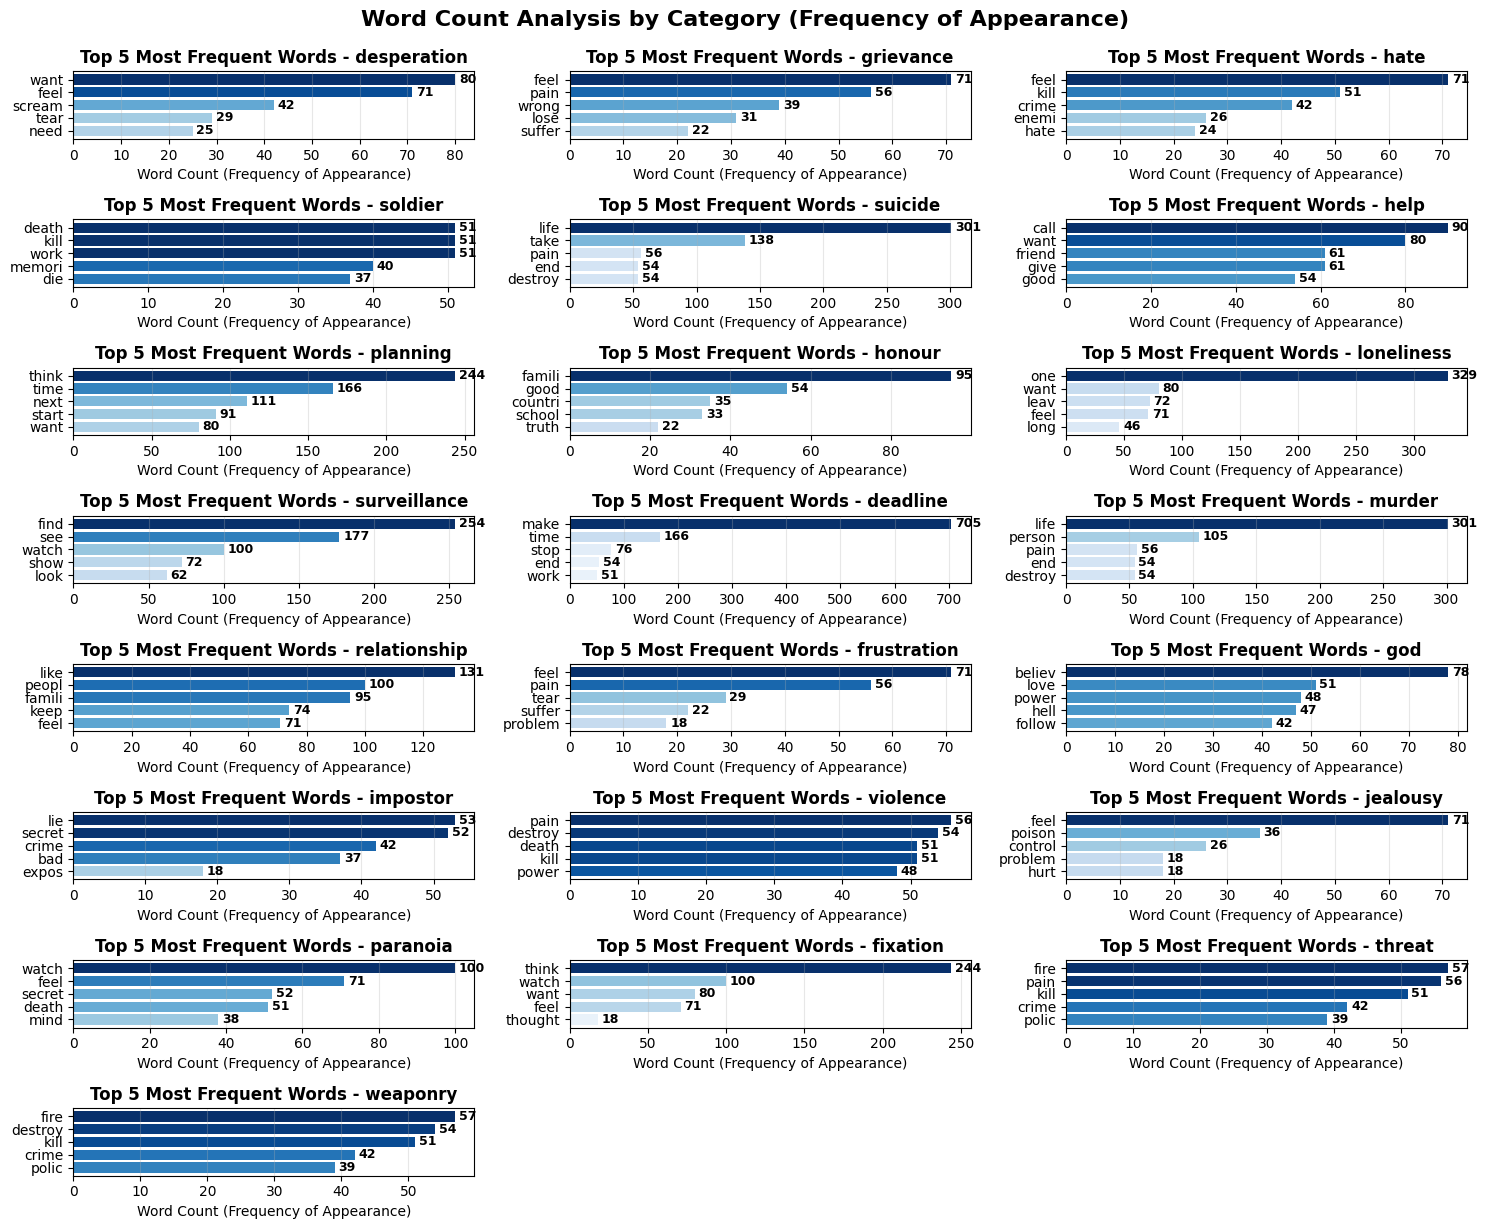

In [22]:
create_count_visualization(matched_words_tel_with_total_df, top_n=5)

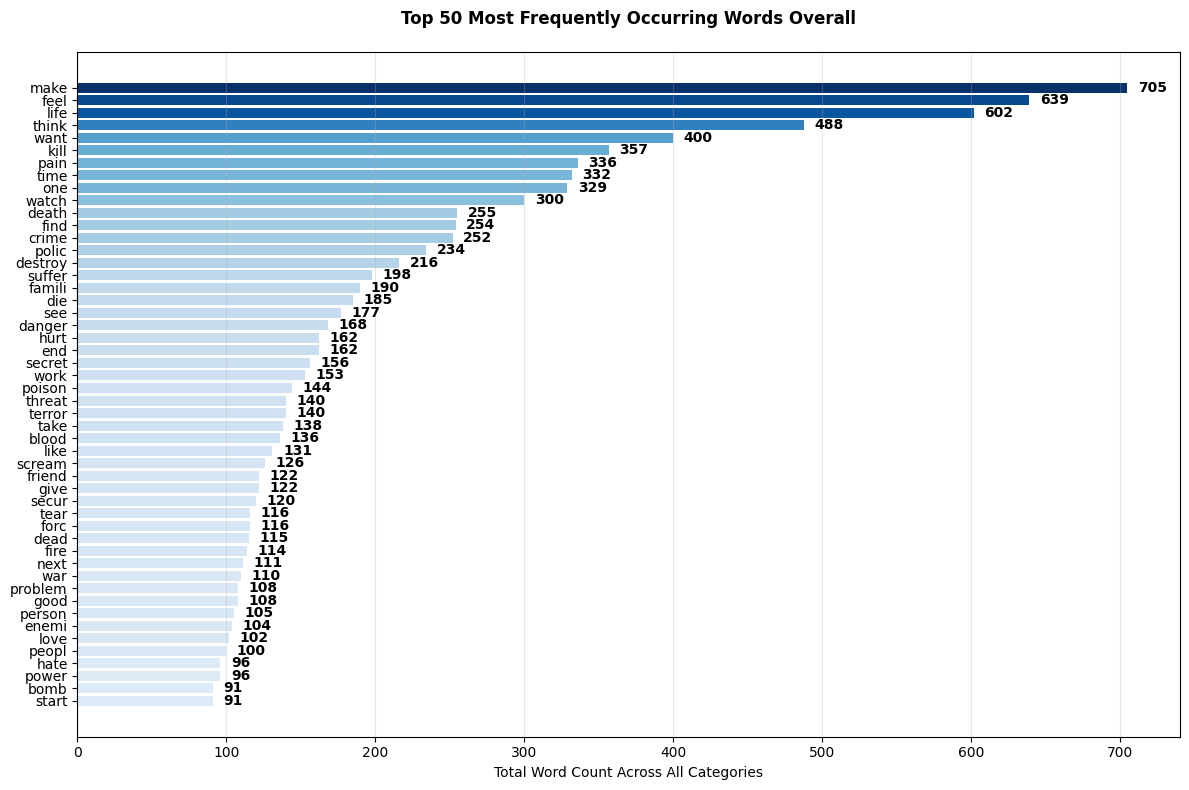

In [23]:
create_top_count_comparison(matched_words_tel_with_total_df, top_n=50)

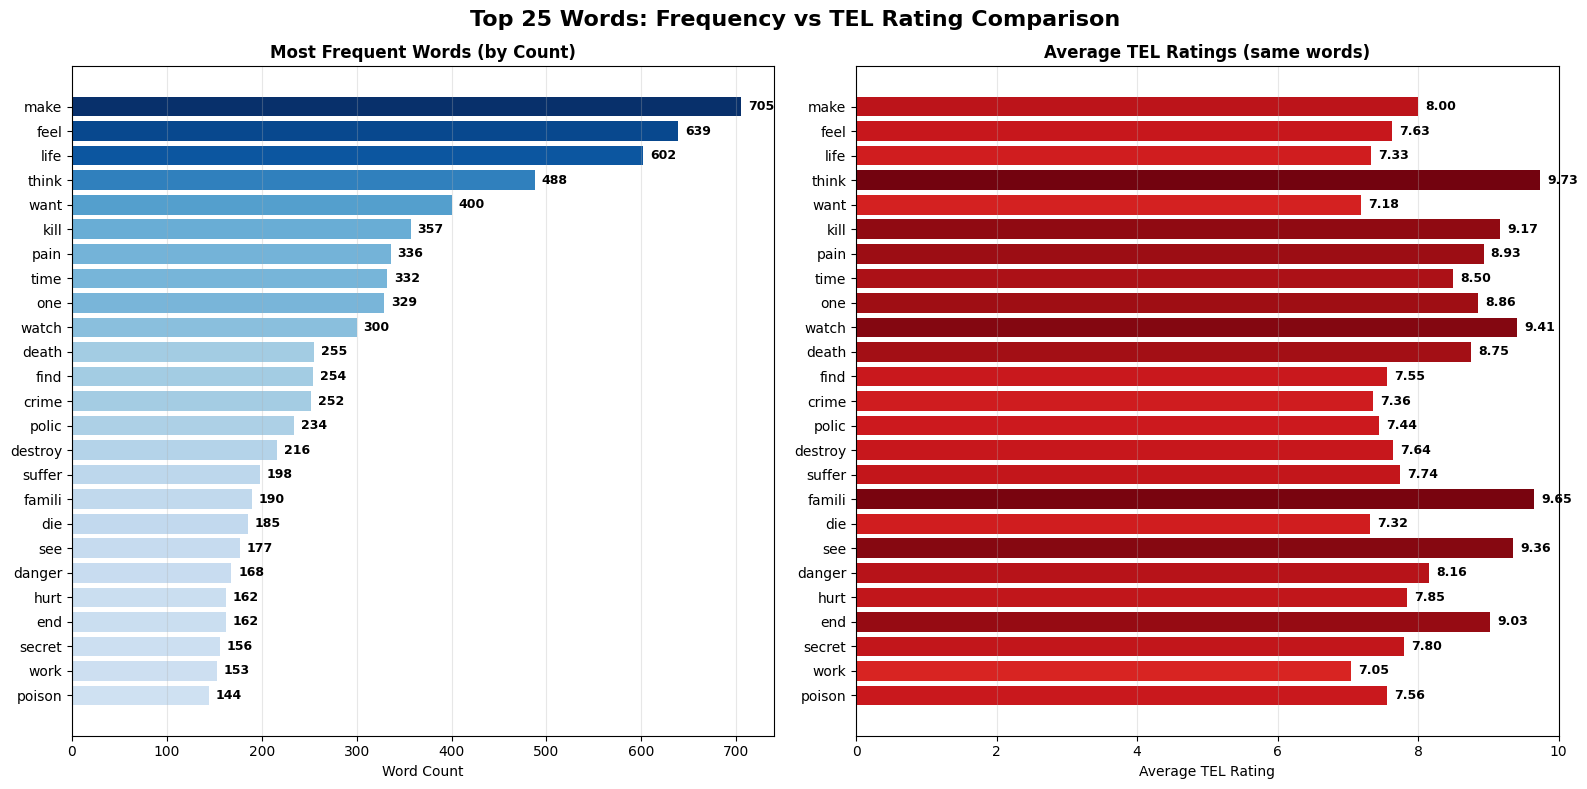

In [24]:
create_count_vs_rating_comparison(matched_words_tel_with_total_df, top_n=25)